In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

In [3]:
!pip install -q mlflow
!pip install -q python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.1/569.1 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.6 MB/s eta 0:00:00


In [4]:
import os
project_folder = '/content/drive/MyDrive/nba-project'
os.chdir(project_folder)
pickles_folder = os.path.join(os.getcwd(), 'datasets')
os.getcwd()

'/content/drive/MyDrive/nba-project'

In [5]:
import custom_modules.modelling_lib_rodrixx as mod
import custom_modules.preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

import xgboost as xgb

from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor, RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv

from mlflow.server import get_app_client
import mlflow

In [6]:
env_path = os.path.join(os.getcwd(), 'env_files', '.env')
load_dotenv(env_path)
dataframes_path = os.path.join(os.getcwd(), 'datasets')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [7]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1982_to_2024.pkl'))

In [8]:
df.head()

,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,FG%,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,0.579,...,20,5,8,0.695,82,3,0.927,31,0.045,690
1,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,0.494,...,10,13,15,0.561,82,10,0.963,0,0.000,690
2,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,0.465,...,48,34,36,0.341,82,36,0.622,0,0.000,690
3,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,0.357,...,22,68,47,0.768,82,1,0.646,0,0.000,690
4,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,0.472,...,45,40,35,0.768,82,1,0.829,0,0.000,690


In [9]:
cols_tot = [col for col in df.columns if '_tot' in col]
cols_to_drop = ['G', 'GS', 'GT', 'Votes', 'MaxVotes', 'Tm']
cols_to_drop += cols_tot
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']
col_to_ohe = 'Pos'

In [10]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('OHE', prep.OHE(col_to_ohe)),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [11]:
df = pipe_clean.fit_transform(df)

In [12]:
df.head()

,,Age,MP_pg,FG_pg,FGA_pg,FG%,3P_pg,3PA_pg,3P%,2P_pg,2PA_pg,...,VORP_rank,%W,%W_rank,%G,Share,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG
Player,Season,,,,,,,,,,,,,,,,,,,,,
Kareem Abdul-Jabbar,1982,34,35.2,9.9,17.1,0.579,0.0,0.0,0.000,9.9,17.1,...,8,0.695,3,0.927,0.045,1,0,0,0,0
Alvan Adams,1982,27,30.3,6.4,13.0,0.494,0.0,0.0,0.000,6.4,13.0,...,15,0.561,10,0.963,0.000,1,0,0,0,0
Mark Aguirre,1982,22,28.8,7.5,16.1,0.465,0.5,1.4,0.352,7.0,14.7,...,36,0.341,36,0.622,0.000,0,0,0,1,0
Danny Ainge,1982,22,10.6,1.5,4.2,0.357,0.1,0.3,0.294,1.4,3.8,...,47,0.768,1,0.646,0.000,0,0,0,0,1
Tiny Archibald,1982,33,31.9,4.5,9.6,0.472,0.1,0.2,0.375,4.4,9.4,...,35,0.768,1,0.829,0.000,0,0,1,0,0


In [13]:
len(df[df.index.get_level_values(1) > 2017]) / len(df)

0.20473953885567892

In [14]:
val_df = df[df.index.get_level_values(1) > 2017]
dev_df = df[df.index.get_level_values(1) <= 2017]

In [15]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'ros', sampling_strategy = .4)

In [16]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [17]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [18]:
mlflow.set_experiment('Ensemble Random Forest & XGBoost')

<Experiment: artifact_location='gs://nba-mvp-prediction-mlflow-artifacts/5', creation_time=1699661473312, experiment_id='5', last_update_time=1699661473312, lifecycle_stage='active', name='Ensemble Random Forest & XGBoost', tags={}>

In [19]:
params_1 = {
    'colsamples_bytree': .7,
    'learning_rate': .2,
    'max_depth': 3,
    'n_estimators': 150,
    'subsample': .7,
    'random_state': 23
}

params_2 = {
    'max_depth': 8,
    'max_features': .5,
    'min_samples_split': 10,
    'n_estimators': 220,
    'random_state': 23
}

In [20]:
with mlflow.start_run():
    estimator_1 = xgb.XGBRegressor(**params_1)
    estimator_2 = RandomForestRegressor(**params_2)

    model = VotingRegressor([('xgb', estimator_1), ('rf', estimator_2)], weights = [.7, .3], verbose = True)

    cv_scores = cross_validate(model, X_train, y_train, scoring = ('neg_root_mean_squared_error', 'r2'), cv = 10)

    model.fit(X_train, y_train)

    params = model.get_params()

    predicted_targets = mod.predict_model(model, datasets)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_ens(params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val']))

[Voting] ...................... (1 of 2) Processing xgb, total=   5.5s
[Voting] ....................... (2 of 2) Processing rf, total=  58.0s
[Voting] ...................... (1 of 2) Processing xgb, total=   1.1s
[Voting] ....................... (2 of 2) Processing rf, total=  52.4s
[Voting] ...................... (1 of 2) Processing xgb, total=   1.1s
[Voting] ....................... (2 of 2) Processing rf, total=  49.2s
[Voting] ...................... (1 of 2) Processing xgb, total=   1.1s
[Voting] ....................... (2 of 2) Processing rf, total=  50.6s
[Voting] ...................... (1 of 2) Processing xgb, total=   1.1s
[Voting] ....................... (2 of 2) Processing rf, total=  49.3s
[Voting] ...................... (1 of 2) Processing xgb, total=   1.1s
[Voting] ....................... (2 of 2) Processing rf, total=  50.0s
[Voting] ...................... (1 of 2) Processing xgb, total=   2.0s
[Voting] ....................... (2 of 2) Processing rf, total=  49.3s
[Votin

2024/11/01 16:17:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/01 16:17:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run shivering-worm-194 at: https://nba-mvp-prediction.xyz/mlflow/#/experiments/5/runs/c541918f6fa94f10a5c3849030305699.
2024/11/01 16:17:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://nba-mvp-prediction.xyz/mlflow/#/experiments/5.


In [21]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.012508,0.014362,0.030174
R2,0.993678,0.978783,0.666624


In [22]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'])

In [23]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Share,PredShare
Player,Season,,
James Harden,2018,0.955,0.960540
LeBron James,2018,0.731,0.428513
Anthony Davis,2018,0.441,0.203906
Damian Lillard,2018,0.205,0.126949
Russell Westbrook,2018,0.075,0.177401
Giannis Antetokounmpo,2018,0.074,0.054638
Kevin Durant,2018,0.065,0.139301
DeMar DeRozan,2018,0.032,0.010928
LaMarcus Aldridge,2018,0.006,0.027760


,,Share,PredShare
Player,Season,,
Giannis Antetokounmpo,2019,0.932,0.651253
James Harden,2019,0.768,0.728169
Paul George,2019,0.352,0.148891
Nikola Jokić,2019,0.210,0.140392
Stephen Curry,2019,0.173,0.106704
Damian Lillard,2019,0.068,0.153924
Joel Embiid,2019,0.049,0.043832
Kevin Durant,2019,0.025,0.186941
Kawhi Leonard,2019,0.013,0.106805


,,Share,PredShare
Player,Season,,
Giannis Antetokounmpo,2020,0.952,0.640762
LeBron James,2020,0.746,0.331906
James Harden,2020,0.363,0.602073
Luka Dončić,2020,0.198,0.069096
Kawhi Leonard,2020,0.166,0.079997
Anthony Davis,2020,0.081,0.274791
Chris Paul,2020,0.026,0.006577
Damian Lillard,2020,0.023,0.179687
Nikola Jokić,2020,0.018,0.041587


,,Share,PredShare
Player,Season,,
Nikola Jokić,2021,0.961,0.603114
Joel Embiid,2021,0.580,0.080042
Stephen Curry,2021,0.449,0.213063
Giannis Antetokounmpo,2021,0.345,0.352004
Chris Paul,2021,0.138,0.020076
Luka Dončić,2021,0.042,0.244706
Damian Lillard,2021,0.038,0.154109
Julius Randle,2021,0.020,-0.002224
Derrick Rose,2021,0.010,0.000239


,,Share,PredShare
Player,Season,,
Nikola Jokić,2022,0.875,0.541985
Joel Embiid,2022,0.706,0.363316
Giannis Antetokounmpo,2022,0.595,0.336596
Devin Booker,2022,0.216,0.085103
Luka Dončić,2022,0.146,0.228032
Jayson Tatum,2022,0.043,0.082695
Ja Morant,2022,0.010,0.187065
Stephen Curry,2022,0.004,0.044427
Chris Paul,2022,0.002,0.070698


,,Share,PredShare
Player,Season,,
Joel Embiid,2023,0.915,0.446573
Nikola Jokić,2023,0.674,0.708597
Giannis Antetokounmpo,2023,0.606,0.401043
Jayson Tatum,2023,0.280,0.162521
Shai Gilgeous-Alexander,2023,0.046,0.137404
Donovan Mitchell,2023,0.030,0.053557
Domantas Sabonis,2023,0.027,0.160895
Luka Dončić,2023,0.010,0.244314
Stephen Curry,2023,0.005,0.036044


,,Share,PredShare
Player,Season,,
Shai Gilgeous-Alexander,2024,0.646,0.453428
Giannis Antetokounmpo,2024,0.194,0.413667
Jalen Brunson,2024,0.143,0.057754
Jayson Tatum,2024,0.087,0.084838
Anthony Edwards,2024,0.018,0.070136
Domantas Sabonis,2024,0.003,0.165190
Kevin Durant,2024,0.001,0.083633


No contenders results:


,,Share,PredShare
Player,Season,,
Álex Abrines,2018,0.0,0.000236
Quincy Acy,2018,0.0,0.000236
Steven Adams,2018,0.0,0.005852
Arron Afflalo,2018,0.0,0.000236
Kadeem Allen,2018,0.0,0.001436
...,...,...,...
Maxwell Lewis,2024,0.0,0.000236
Jalen Crutcher,2024,0.0,0.000080
Kaiser Gates,2024,0.0,0.000080


In [24]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Share,PredShare
Player,Season,,
Ben Simmons,2018,0.0,0.100995
Trevon Duval,2019,0.0,0.166484
Bradley Beal,2020,0.0,0.111738
Zion Williamson,2020,0.0,0.129895
Bradley Beal,2021,0.0,0.139558
Joel Embiid,2024,0.0,0.389783
Luka Dončić,2024,0.0,0.323618
Nikola Jokić,2024,0.0,0.845885


In [25]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'])

(<Figure size 4000x4000 with 8 Axes>, <Figure size 4000x4000 with 8 Axes>)

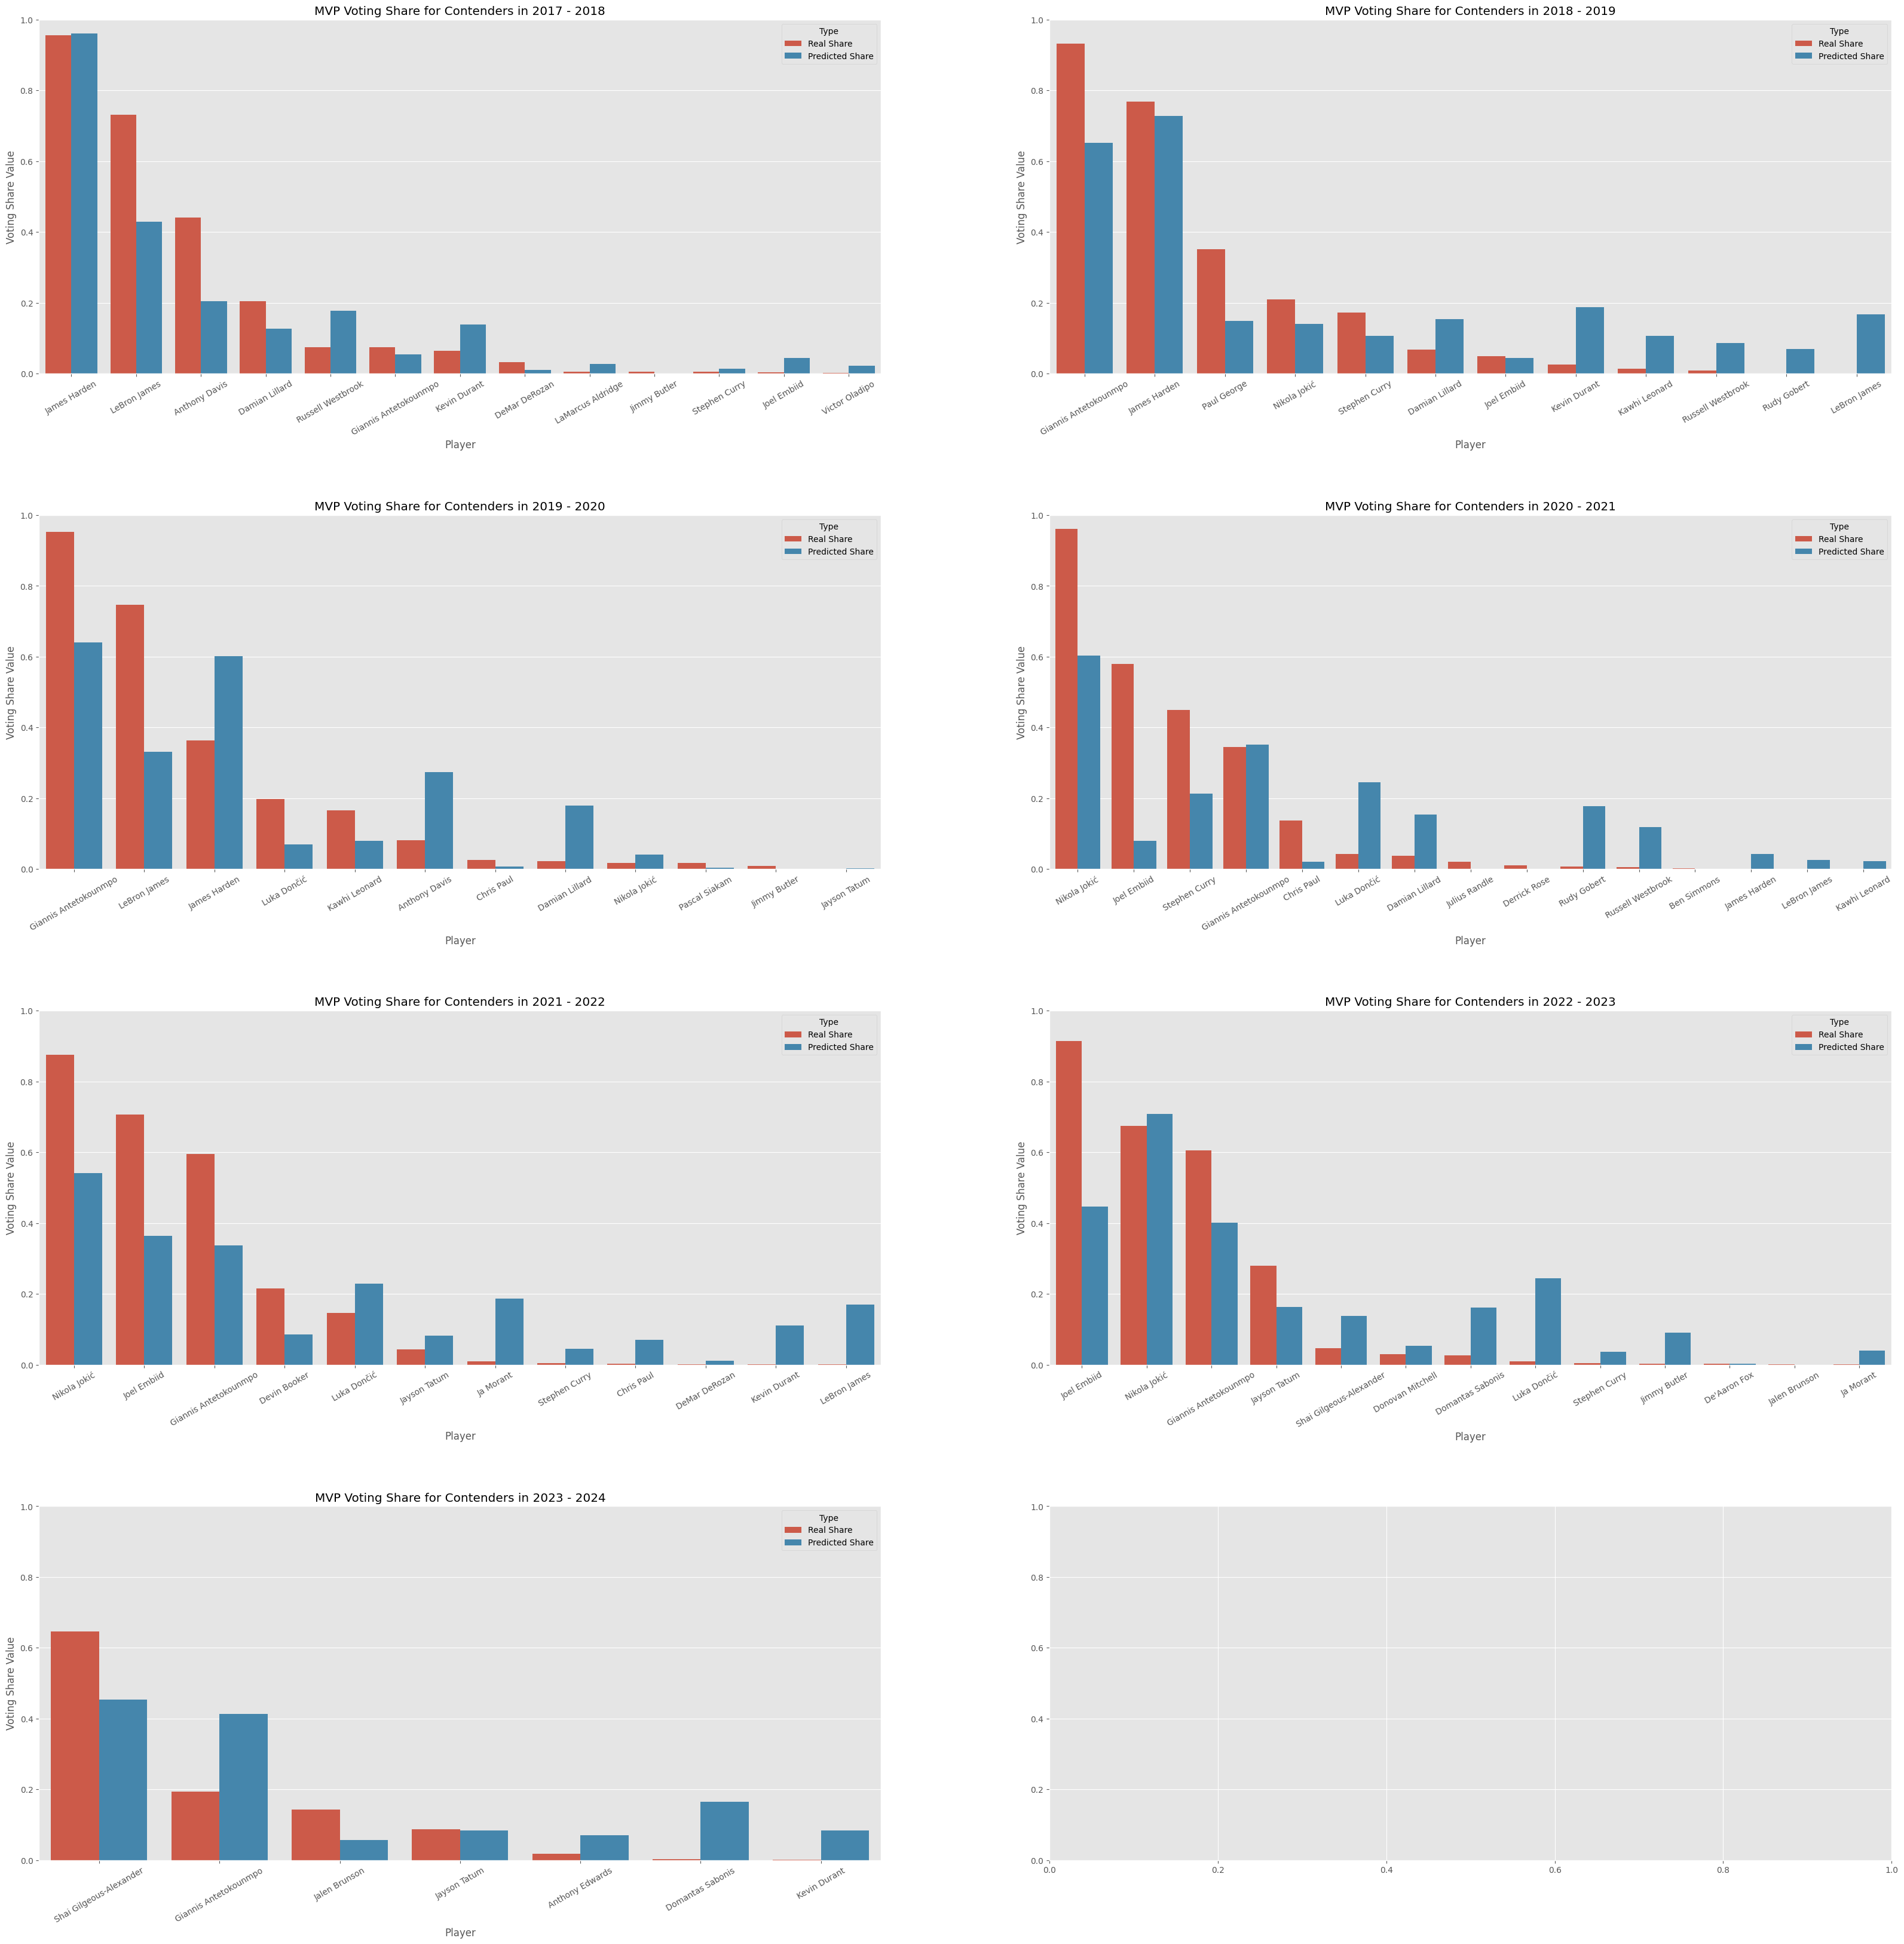

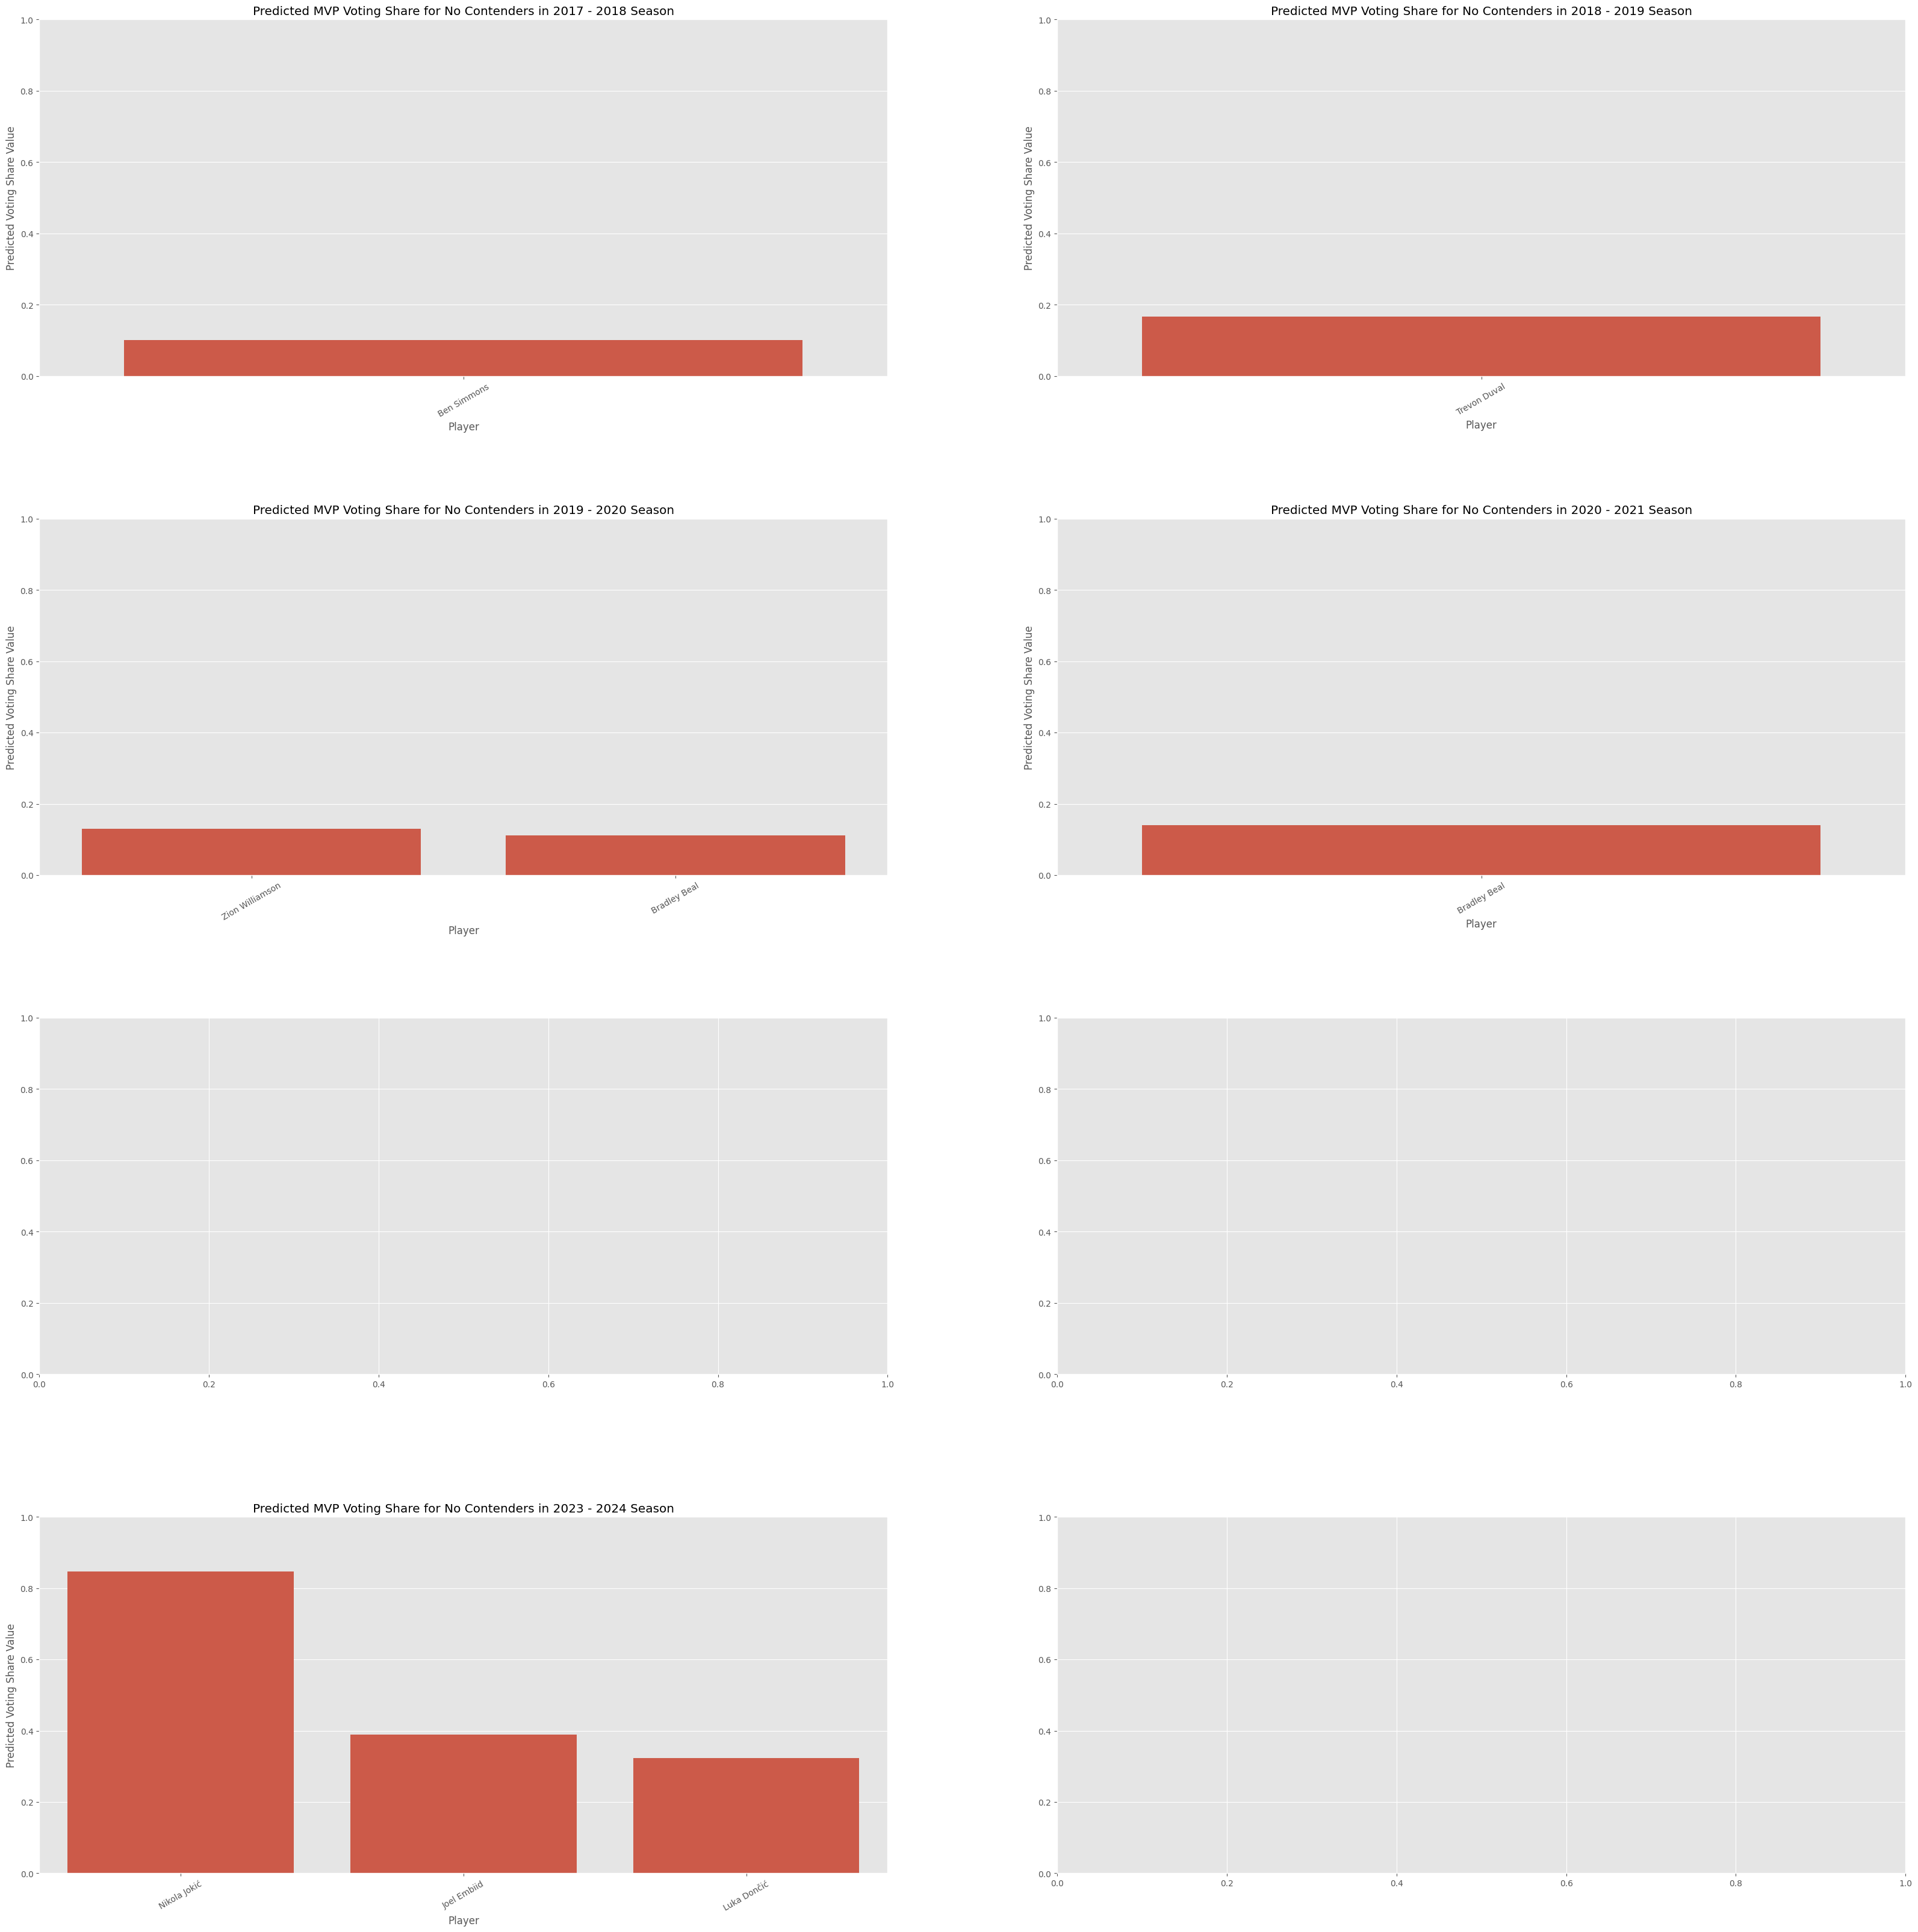

In [26]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'])